<a href="https://colab.research.google.com/github/joaoholandaa/sentimentos-clientes-ecommerce/blob/main/sentimentos_clientes_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLN - Análise de Satisfação dos Clientes do E-commerce <br>
**Olist**: A plataforma olist está presente nos principais canais online do Brasil. É a maior loja de departamentos no mercado brasileiro. <br>
www.olist.com

# 1. Problema de Negócio - Entendendo seus clientes.


1. Compreender as avaliações dos clientes, pois elas são cruciais para o sucesso de uma empresa. <br>
2. Avaliar o sentimento do cliente em relação à marca.

A análise dos comentários ajuda a discernir adequadamente as diferentes preferências, gostos e desgostos do cliente. Esses insights extraídos podem ser usados para melhorar o serviço e a experiência do cliente.

# 2. Análise Exploratória dos Dados.

## **Fonte de Dados**: <br>
Este é um conjunto de dados público de comércio eletrônico brasileiro de pedidos feitos na Olist Store. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 feitos em diversos mercados no Brasil.

Seus recursos permitem a visualização de um pedido em múltiplas dimensões: desde o status do pedido, preço, desempenho de pagamento e frete até a localização do cliente, atributos do produto e, **finalmente, avaliações escritas pelos clientes**. Também lançamos um conjunto de dados de geolocalização que relaciona os códigos postais brasileiros às coordenadas lat/log.

Estes **são dados comerciais reais**, foram anonimizados e as referências às empresas e parceiros no texto da avaliação foram substituídas pelos nomes das grandes casas de Game of Thrones.

In [ ]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ferramentas NLTK para processamento de texto
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Pacotes de modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
# Lendo os dados
review_df = pd.read_csv('/content/drive/MyDrive/ciencia-de-dados/projetos/satisfacao-dos-clientes/olist_order_reviews_dataset.csv')
review_df.head()
review_df.shape

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


(99224, 7)

In [ ]:
# Temos valores faltantes nas revisões e nos títulos
review_df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

# 3. Pré-Processamento

O conjunto de dados de revisão tem uma quantidade significativa de valores NaN no texto e no título das revisões, portanto, teríamos certeza de eliminar esses valores ausentes e redefinir o índice.

Assim com as tarefas normais do dia-a-dia da PLN, precisamos implementar algumas etapas de pré-processamento necessárias que envolvem: transformar os dados das revisões removendo stopwords, usando o módulo de expressão regular para aceitar apenas letras, tokenizando o texto e tomando todas as palavras em minúsculas para consistência.

In [ ]:
# Separando em dois campos de estudo: estudando separadamente título e descrição da avaliação
review_data_title = review_df['review_comment_title']
review_data = review_df.drop(['review_comment_title'], axis=1)

In [ ]:
# Retirando valores NaN
review_data = review_data.dropna()
review_data_title = review_data_title.dropna()

In [ ]:
review_data_title

9                        recomendo
15                 Super recomendo
19         Não chegou meu produto 
22                           Ótimo
34                      Muito bom.
                   ...            
99192                            👍
99196           muito bom produto 
99197    Não foi entregue o pedido
99199              OTIMA EMBALAGEM
99200               Foto enganosa 
Name: review_comment_title, Length: 11568, dtype: object

In [ ]:
# Resetando os índices das revisões e visualizando os dados
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


(40977, 6)

In [ ]:
# Resetando os índices das revisões e visualizando os dados
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(10)
review_data_title.shape

0                  recomendo
1            Super recomendo
2    Não chegou meu produto 
3                      Ótimo
4                 Muito bom.
5                        Bom
6               Maravilhoso!
7           Entrega perfeita
8                      Ótimo
9                   MT lindo
Name: review_comment_title, dtype: object

(11568,)

A partir das células de código acima, podemos deduzir que 58% dos clientes não deixaram comentários e apenas 11,7% dos clientes se preocuparam em dar títulos aos seus comentários.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ", words) # Somente letras
    tokens = nltk.word_tokenize(only_letters) # tokenizar as sentenças
    lower_case = [l.lower() for l in tokens] # converter todas as letras
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # Remove stopwords dos comentários
    comments.append(' '.join(filtered_result))

In [ ]:
comments

['recebi bem antes prazo estipulado',
 'parab ns lojas lannister adorei comprar internet seguro pr tico parab ns todos feliz p scoa',
 'aparelho eficiente site marca aparelho impresso desinfector chegar outro nome atualizar marca correta vez aparelho',
 'pouco travando valor ta boa',
 'vendedor confi vel produto ok entrega antes prazo',
 'gostaria saber sempre recebi compra agora decpcionou',
 'p ssimo',
 'loja nota',
 'obrigado aten amim dispensada',
 'compra realizada facilmente entrega efetuada antes prazo dado produto j come usado at presente problemas',
 'rel gio bonito barato',
 'n gostei comprei gato lebre',
 'sempre compro internet entrega ocorre antes prazo combinado acredito prazo m ximo stark prazo m ximo j esgotou ainda n recebi produto',
 'recebi exatamente esperava demais encomendas outros vendedores atrasaram chegou prazo',
 'recomendo',
 'boa',
 't completamente apaixonada loja super respons vel confi vel',
 'nada chegar pedido',
 'bom cheiroso',
 'otimo vendedor chegou

Visualização de dados após o pré-processamento de nossos dados, é hora de visualizar nosso texto de revisão usando WordCloud. Uma WordCloud é uma representação visual dos dados do texto envolvidos e mostra a importância das palavras pelo tamanho da fonte.

<Figure size 2000x1200 with 0 Axes>

(-0.5, 1999.5, 999.5, -0.5)

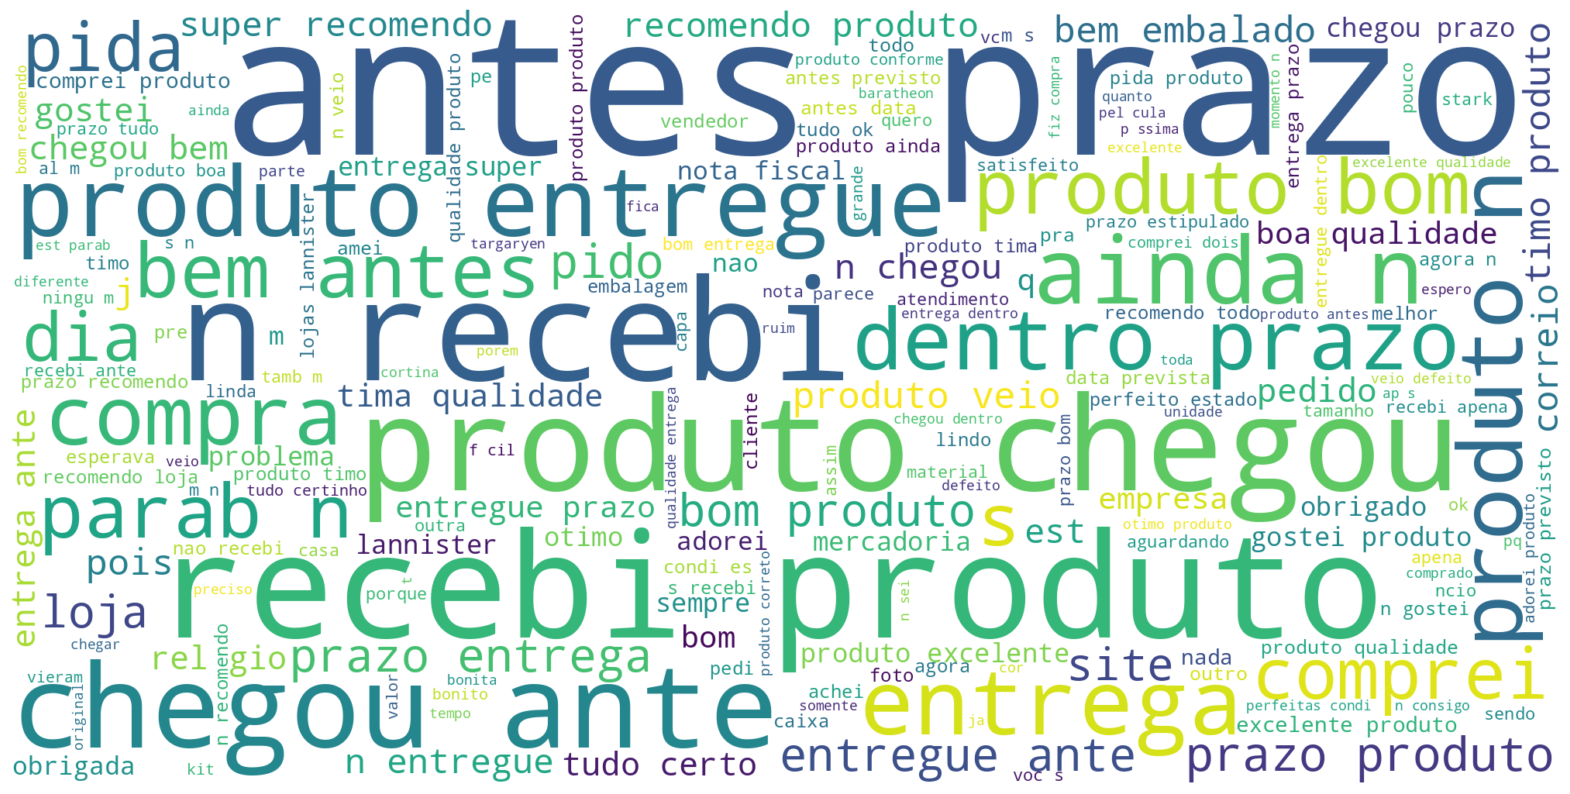

In [ ]:
# Visualizando os dados limpos das revisões
# comentários

# Usando wordcloud para visualizar os comentários
unique_string=(" ").join(comments)
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Usando CountVectorizer para pegar os unigramas mais importantes
co = CountVectorizer(ngram_range=(1,1))
counts = co.fit_transform(comments)
important_unigrams = pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)

In [ ]:
important_unigrams

,0
produto,18429
prazo,8475
entrega,6532
antes,5626
chegou,5555
...,...
margarina,1
consideravelmente,1
considerei,1
marerial,1


In [ ]:
# Usando CountVectorizer para pegar os bigramas mais importantes
co = CountVectorizer(ngram_range=(2,2))
counts = co.fit_transform(comments)
important_bigrams = pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)

In [ ]:
important_bigrams

,0
antes prazo,4193
recebi produto,1873
produto chegou,1700
produto entregue,1595
chegou antes,1460
...,...
espero novas,1
espero nao,1
espero mesma,1
espero meses,1


In [ ]:
# Usando CountVectorizer para pegar os trigramas mais importantes
co = CountVectorizer(ngram_range=(3,3))
counts = co.fit_transform(comments)
important_trigrams = pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0, ascending=False)

In [ ]:
important_trigrams

,0
chegou antes prazo,1108
bem antes prazo,706
entregue antes prazo,608
produto chegou antes,448
entrega antes prazo,432
...,...
entregue bolsa porta,1
entregue bom antes,1
entregue boneca qdo,1
entregue brinde obrigado,1


Observações
1. Dos unigramas, bigramas e trigramas acima, podemos afirmar com segurança que a maioria dos clientes ficou satisfeita com o serviço de entrega, alguns outros ficaram muito satisfeitos com a qualidade dos produtos.
2. No entanto, existem outros que não ficaram satisfeitos com os serviços prestados e gostaríamos de aprofundar esta anomalia. Traçando as pontuações de revisão antes e depois de remover os valores NaN.

Após remover os valores NaN, cerca de 10.000 pessoas deram avaliações de 1 estrela, enquanto um pouco mais de 20.000 pessoas deram avaliações de 5 estrelas, o que significa que:
1. Cerca de 36% dos revisores de 5 estrelas deram comentários, enquanto 79% dos revisores de 1 estrela deram comentários, então um cliente era mais propenso a fazer comentários quando ele/ela estava insatisfeito.
2. Para entender adequadamente os clientes insatisfeitos, deve ser construído um modelo de análise de sentimento que classifique esses sentimentos. Mas, antes de fazermos isso, precisamos também dar uma olhada nos títulos das avaliações

In [ ]:
# Processando os dados de títulos das revisões
comments_titles = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data_title:
    only_letters = re.sub("[^a-zA-Z]", " ", words) # Somente letras
    tokens = nltk.word_tokenize(only_letters) # tokenizar as sentenças
    lower_case = [l.lower() for l in tokens] # converter todas as letras em minúsculas
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # Remove stopwords dos comentários

    comments_titles.append(' '.join(filtered_result))

In [ ]:
comments_titles

['recomendo',
 'super recomendo',
 'n chegou produto',
 'timo',
 'bom',
 'bom',
 'maravilhoso',
 'entrega perfeita',
 'timo',
 'mt lindo',
 'timo produto',
 'recomendo sempre',
 'recomendo',
 'n recebi produto',
 'otimo',
 'entrega atrasou',
 'boa',
 '',
 'm dio',
 'prazo entrega',
 'super produto',
 'falta produto quebra',
 'super recomendo',
 'n recebi ainda',
 'recomendo',
 'nota',
 'suspense',
 'entrega antes previsto',
 'recomendo',
 'top',
 'produto show',
 'super recoendo',
 'erraram caixa ac stica',
 'tima compra',
 'horr vel',
 'super recomendo',
 'bom',
 'otimo',
 '',
 'recomendo',
 'bom',
 'lamenet vel',
 'qualidade ruim',
 'insatisfeito',
 'mega recomendo',
 'excelente produto',
 'recomendo',
 'nao entrega produto',
 'recomendo',
 'captador presys blend',
 'produto pirata',
 'produto fraco',
 'nota',
 'tudo certo',
 'recomendo',
 'timo',
 'otimo',
 'perfeito',
 'lol pet',
 'bom',
 'excelente',
 '',
 'timo custo x benef cio',
 'bom',
 'produto entrega timos',
 'produto ok',


<Figure size 2000x1200 with 0 Axes>

(-0.5, 1999.5, 999.5, -0.5)

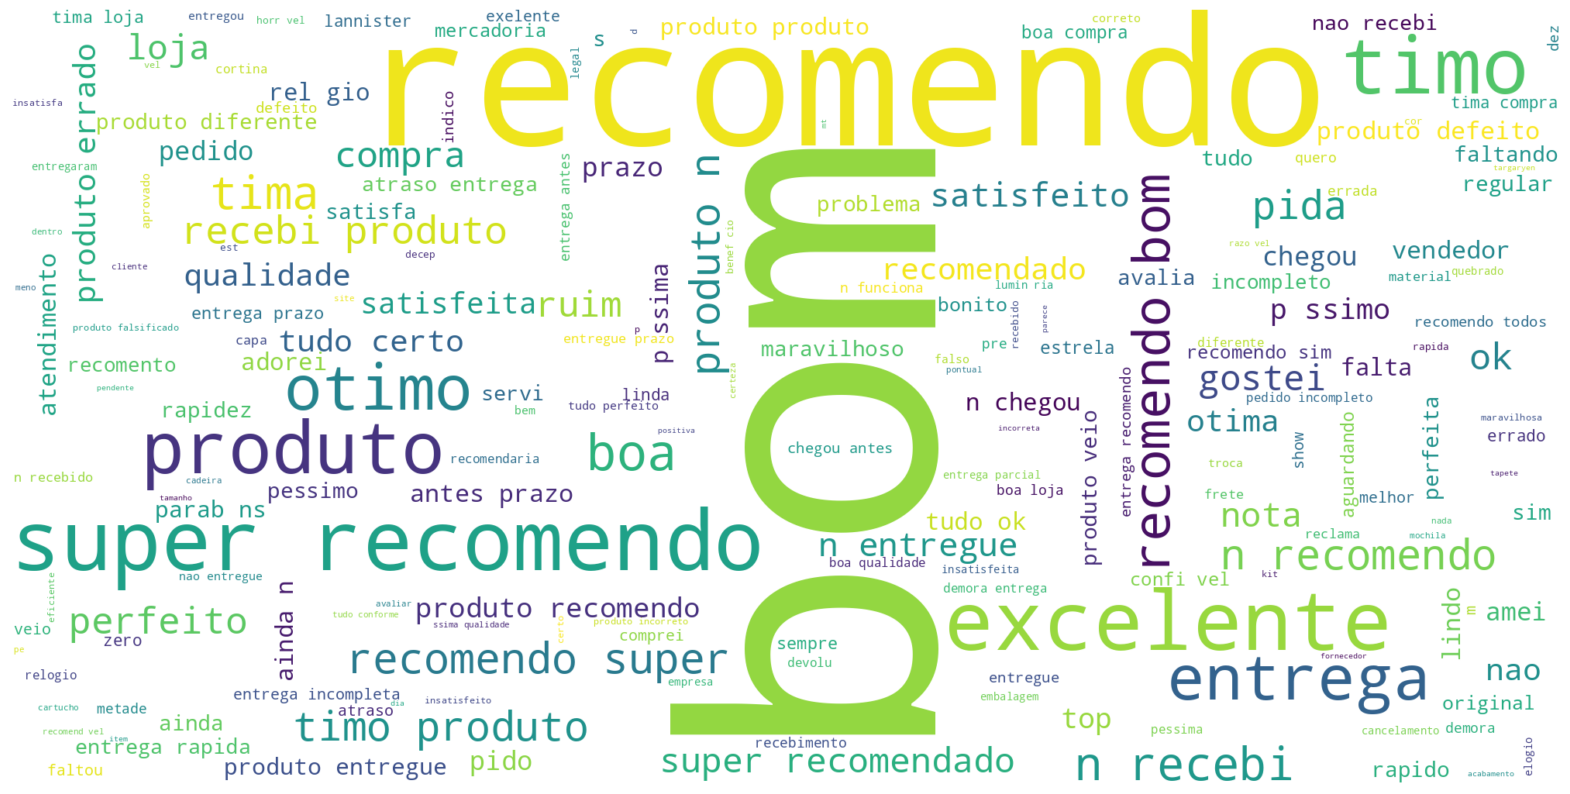

In [ ]:
# Usando wordcloud para visualizar os títulos dos comentários
unique_string=(" ").join(comments_titles)
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Usando CountVectorizer para pegar os unigramas mais importantes
co = CountVectorizer(ngram_range=(1,1))
counts = co.fit_transform(comments_titles)
important_unigrams_title = pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)

In [ ]:
important_unigrams_title

,0
recomendo,2071
bom,1315
produto,1290
super,896
timo,730
...,...
free,1
fraude,1
fragil,1
fragi,1


In [ ]:
# Usando CountVectorizer para pegar os bigramas mais importantes
co = CountVectorizer(ngram_range=(2,2))
counts = co.fit_transform(comments_titles)
important_bigrams_title = pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)

In [ ]:
important_bigrams_title

,0
super recomendo,678
recebi produto,121
timo produto,103
super recomendado,101
produto entregue,98
...,...
faluana receber,1
farol led,1
farol milha,1
fase teste,1


In [ ]:
# Usando CountVectorizer para pegar os trigramas mais importantes
co = CountVectorizer(ngram_range=(3,3))
counts = co.fit_transform(comments_titles)
important_trigrams_title = pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)

In [ ]:
important_trigrams_title

,0
entrega super pida,27
entrega antes prazo,15
custo benef cio,12
chegou antes prazo,11
nao recebi produto,11
...,...
ja pedi devolucao,1
jeane jesus silva,1
jeito est an,1
jogo len ol,1


Observações: <br>
Os unigramas, bigramas, trigramas dos dados dos títulos das avaliações revelaram ainda mais os comentários infelizes de clientes insatisfeitos. Esses comentários incluem:
- Receber entrega incompleta.
- Não receber as mercadorias encomendadas. <br>

Até agora, essas foram as principais reclamações de clientes insatisfeitos e também observamos um alto grau de satisfação entre outros clientes.

Antes de construir o modelo de análise de sentimento, realizaremos EDA extra benéfico para outros insights.

In [ ]:
# Verificando o percentual dos scores das revisões, 3 e 4 são os menores scores
percent_scores = 100 * review_data['review_score'].value_counts()/len(review_data)
percent_scores

5    50.159846
1    21.341240
4    14.583791
3     8.680479
2     5.234644
Name: review_score, dtype: float64

# 4. Máquina Preditiva de Análise de Sentimentos

Este seria um caso de aprendizado supervisionado, portanto, teríamos que criar uma nova coluna representando a pontuação de sentimento (1 ou 0). 1 é para palavras positivas e 0 para palavras negativas. Excluiríamos a pontuação de revisão de 3 pontos porque representa neutra e incluiríamos as pontuações de 1 e 2 como palavras negativas e as pontuações de 4 e 5 na revisão para palavras positvas.

In [ ]:
# Mapeando os ratings
review_data['Sentiment_rating'] = np.where(review_data.review_score > 3,1,0)

# Removendo revisões neutras
review_data = review_data[review_data.review_score != 3]

# Printando a contagem de cada classe
review_data['Sentiment_rating'].value_counts()

1    26530
0    10890
Name: Sentiment_rating, dtype: int64

In [ ]:
review_data.head()
review_data['Sentiment_rating'].shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,Sentiment_rating
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,1
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1


(37420,)

In [ ]:
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ", words) # Somente letras
    tokens = nltk.word_tokenize(only_letters) # tokenizar as sentenças
    lower_case = [l.lower() for l in tokens] # converter todas as letras em minúsculas
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # Remove stopwords dos comentários

    comments.append(' '.join(filtered_result))

In [ ]:
co_counts = CountVectorizer(stop_words=list(stopwords.words('portuguese')),
                            ngram_range=(1,4)) # unigrama para trigrama
co_data = co_counts.fit_transform(comments)

In [ ]:
co_data

<37420x402321 sparse matrix of type '<class 'numpy.int64'>'
	with 833979 stored elements in Compressed Sparse Row format>

In [ ]:
# Separando a coluna de score dos sentimentos em dados de treino e teste
X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(co_data,
                                                                review_data['Sentiment_rating'],
                                                                test_size=0.2,
                                                                random_state=7)

In [ ]:
y_test_co.value_counts()/y_test_co.shape[0]
#71% dos sentimentos são classificados como positivos
#29% dos sentimentos são classificados como negativo

1    0.710449
0    0.289551
Name: Sentiment_rating, dtype: float64

In [ ]:
# Definindo e treinando o modelo
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_co, y_train_co)

LogisticRegression(max_iter=200)

# 5. Avalição da Máquina Preditiva

In [ ]:
# Predição dos resultados
test_pred = lr_model.predict(X_test_co)

print("Acurácia: ", accuracy_score(y_test_co, test_pred))
print("F1 score: ", f1_score(y_test_co, test_pred))
print("Confusion Matrix: ", confusion_matrix(y_test_co, test_pred))

Acurácia:  0.9259754142169963
F1 score:  0.9482726423902894
Confusion Matrix:  [[1852  315]
 [ 239 5078]]


In [ ]:
lr_weights = pd.DataFrame(list(zip(co_counts.get_feature_names_out(), # pegando todos as feature names dos n-gramas
                                   lr_model.coef_[0])), # pegando os coeficientes da regressão logística
                          columns=['words', 'weights']) # definindo os nomes das colunas

positive_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending=False)[:15])
positive_sentiments

,words,weights
158281,excelente,3.090531
370770,timo,3.052874
243896,otimo,2.788588
263047,pido,2.691588
16388,amei,2.671283
44366,bom,2.563924
205208,lindo,2.451732
259763,perfeito,2.435174
5757,adorei,2.330605
262005,pida,2.325021


In [ ]:
negative_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending=False)[-15:])
negative_sentiments

,words,weights
261354,pessima,-1.590640
33322,atrasada,-1.644284
139489,entregaram,-1.678513
105106,demora,-1.704599
252460,passou,-1.704601
321456,recebi,-1.704984
261425,pessimo,-1.726396
145993,enviaram,-1.733882
193821,insatisfeita,-1.763899
315170,quebrado,-1.796320


# Trabalhos Futuros <br>

Aqui estão alguns tópicos para possíveis resultados deste conjunto de dados.

**PLN**: Este conjunto de dados oferece um ambiente para analisar o texto das avaliações em suas múltiplas dimensões.

**Clustering**: Alguns clientes não escreveram um comentário. Por qual motivo?

**Previsão de vendas**: Com as informações de data de compras, poderá ser previsto vendas futuras.

**Desempenho de entrega**: Encontrar maneiras de otimizar os tempos de entrega.

**Qualidade do produto**: Categorias de produtos que são mais propensas à insatisfação do cliente.

**Engenharia de recursos**: Criar recursos a partir deste conjunto de dados ou anexar informações públicas externas.
